In [1]:
seed=1226

In [2]:
import warnings
# warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['PYTHONHASHSEED']=str(seed)

In [3]:
import tensorflow as tf


tf.random.set_seed(seed)

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense,Input,Reshape, Flatten,ELU,RepeatVector,TimeDistributed, Bidirectional, PReLU, Concatenate, Subtract
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tqdm import tqdm
from keras.optimizers import Nadam

import glob
import keras
from datetime import datetime
from keras.callbacks import EarlyStopping
import time
# from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
# from sklearn.metrics import r2_score
from keras.utils import plot_model
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
np.random.seed(seed)
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
from keras.utils import to_categorical
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import pacf
%matplotlib inline
from matplotlib.pylab import rcParams
# import seaborn as sns
rcParams['figure.figsize']=15,5

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [4]:
from time import time


import pandas as pd
import random

# For plotting
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import plotly.graph_objects as go

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,7)})

#For standardising the dat
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.manifold import TSNE

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

In [5]:
def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
Stations = os.listdir('Clean-dataset-LMS')
# Stations.remove('.DS_Store')

In [7]:
Stations

['clean_deep_LMS Data - chola kangra.csv',
 'clean_deep_LMS Data - Kuppa_Kinnaur.csv',
 'clean_deep_LMS Data - Ghoro_Farm_1.csv',
 'clean_deep_LMS Data - Ghoro_Farm_2.csv',
 'clean_deep_LMS Data - Sanarli_2_Mandi.csv',
 'clean_deep_LMS Data - Pagal_Nala_Kinnaur.csv',
 'clean_deep_LMS Data - macleodganj kangra.csv',
 'clean_deep_LMS Data - Purbani_Kinnaur.csv',
 'clean_deep_LMS Data - Sanarli_3_Mandi.csv',
 'clean_deep_LMS Data - griffon peak 3.csv',
 'clean_deep_LMS Data - Batseri_Kinnaur.csv',
 'clean_deep_LMS Data - Ghoda Farm 5.csv',
 'clean_deep_LMS Data - Ghoda Farm 4.csv',
 'clean_deep_LMS Data - Rulehr_Shahpur_Kangra.csv',
 'clean_deep_LMS Data - griffon peak 4.csv',
 'clean_deep_LMS Data - Garudnala_Mandi.csv',
 'clean_deep_LMS Data - griffon peak 5.csv',
 'clean_deep_LMS Data - Ghoda Farm 3.csv',
 'clean_deep_LMS Data - Griffon peak 6.csv',
 'clean_deep_LMS Data - Nigulsari_Kinnaur.csv',
 'clean_deep_LMS Data - Urni_Dhank_Kinnaur.csv',
 'clean_deep_LMS Data - Sanarli_1_Mandi.c

In [8]:
Column = ['Date','Tem','Hum','Pressure','Rain','Light','Ax','Ay','Az','Wx','Wy','Wz','Moisture','Count']

In [9]:
seq_len = 10

In [10]:
def matrix(model, Train,TrainL,Test, TestL):
    f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row')
    Predict=[]
    True_cls=[]
    test=Train
    y=TrainL

    P=model.predict(test,verbose=0)
    Predict=np.argmax(P,axis=1)
    True_cls=np.argmax(y,axis=1)

    cm = confusion_matrix(True_cls, Predict, labels=[0,1])
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Mov','Mov'])
    disp1.plot(ax=axes[0])
    
    disp1.im_.colorbar.remove()
    train_acc = (cm[0][0]+cm[1][1])/np.sum(cm)

    Predict2=[]
    True_cls2=[]
    test=Test
    y=TestL
    P=model.predict(test,verbose=0)
    Predict2=np.argmax(P,axis=1)
    True_cls2=np.argmax(y,axis=1)

    cm = confusion_matrix(True_cls2, Predict2, labels=[0,1])
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Mov','Mov'])
    disp2.plot(ax=axes[1])
    disp2.im_.colorbar.remove()
    
    # Evaluate model accuracy on training and testing sets
    
    test_acc = (cm[0][0]+cm[1][1])/np.sum(cm)

    # Display accuracy values on subplots
    axes[0].set_title('Training Set\nAccuracy: {:.2f}%'.format(train_acc * 100))
    axes[1].set_title('Testing Set\nAccuracy: {:.2f}%'.format(test_acc * 100))


    
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    plt.show()

In [11]:
#Rearrange the Array
def makeArray(Array):
    New=np.array(Array[0])

    for i in range(1,len(Array)):
        New = np.append(New,Array[i],axis=0)
        
    return New

In [12]:
def readData(Stations):
    
    Data, C = [], []
    
#     print(Stations)
    file = Stations
    newfile = file
    df = pd.read_csv('Clean-dataset-LMS/'+newfile, header=0, index_col=None)
    print(newfile)
    df = df.reset_index(drop=True)
    data=df[['Tem','Hum','Pressure','Rain','Light','Ax','Ay','Az','Wx','Wy','Wz','Moisture','Count']].values
    data=data.astype('float32')
    data[np.where(data[:,-1]>0),-1] = 1
    count=df['Count'].values
    count=count.astype('float32')

    #Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    Data.append(data)
    C.append(count)
   
    return makeArray(Data), makeArray(C)


In [13]:
Data=[[] for x in range(len(Stations))]
Count=[[] for x in range(len(Stations))]
for i in range(len(Stations)):
    Data[i], Count[i] = readData(Stations[i])

clean_deep_LMS Data - chola kangra.csv
clean_deep_LMS Data - Kuppa_Kinnaur.csv
clean_deep_LMS Data - Ghoro_Farm_1.csv
clean_deep_LMS Data - Ghoro_Farm_2.csv
clean_deep_LMS Data - Sanarli_2_Mandi.csv
clean_deep_LMS Data - Pagal_Nala_Kinnaur.csv
clean_deep_LMS Data - macleodganj kangra.csv
clean_deep_LMS Data - Purbani_Kinnaur.csv
clean_deep_LMS Data - Sanarli_3_Mandi.csv
clean_deep_LMS Data - griffon peak 3.csv
clean_deep_LMS Data - Batseri_Kinnaur.csv
clean_deep_LMS Data - Ghoda Farm 5.csv
clean_deep_LMS Data - Ghoda Farm 4.csv
clean_deep_LMS Data - Rulehr_Shahpur_Kangra.csv
clean_deep_LMS Data - griffon peak 4.csv
clean_deep_LMS Data - Garudnala_Mandi.csv
clean_deep_LMS Data - griffon peak 5.csv
clean_deep_LMS Data - Ghoda Farm 3.csv
clean_deep_LMS Data - Griffon peak 6.csv
clean_deep_LMS Data - Nigulsari_Kinnaur.csv
clean_deep_LMS Data - Urni_Dhank_Kinnaur.csv
clean_deep_LMS Data - Sanarli_1_Mandi.csv
clean_deep_LMS Data - dharamshala kangra.csv


In [14]:
def make_packet(D, C, seq_len):
    Packet_data = []
    Packet_label = []
    Packet_count = []

    for i in range(len(D)-seq_len):
        Packet_data.append(D[i:i+seq_len,:])
        Packet_label.append(D[i+seq_len,:])
        Packet_count.append(C[i+seq_len])

    Packet_data = np.array(Packet_data)
    Packet_label = np.array(Packet_label)
    Packet_count = np.array(Packet_count).reshape(-1,1)
    
    return Packet_data, Packet_label, Packet_count

def balance_data(d1, l1, c1):
    P1 = []
    L1 = []
    C1 = []
    count = 0
    for i in range(len(c1)):
        if c1[i]>0:
            P1.append(d1[i])
            L1.append(l1[i])
            C1.append(c1[i])
            count+=1

            reset_random_seeds(seed)
    idx = np.random.permutation(len(c1))        

    P2 = []
    L2 = []
    C2 = []
    idx1 = -1
    while count!=0:
        idx1+=1
        if c1[idx[idx1]] == 0:
            P2.append(d1[idx[idx1]])
            L2.append(l1[idx[idx1]])
            C2.append(c1[idx[idx1]])
            count-=1

    #Make the movement count to 1
    #Comment this line if you want to movement count
    C1=list(np.ones((len(C1))).reshape(-1,1))
    
    P1 = P1+P2
    L1 = L1+L2
    C1 = C1+C2
    P1 = np.array(P1)
    L1 = np.array(L1)
    C1 = np.array(C1)
    
    return P1, L1, C1

def mold(D):
    T = []
    for x in D:
        for t in x:
            T.append(t)
            
    return np.array(T)

In [15]:
def train_test(Data, Count, seq_len):
    print("Train:")
    print()
    Train = []
    Train_label = []
    Train_count = []
    S = [1,2,3,4,5,6,7,8,9,10,11,12]
    for i in S:
        D = Data[i]
        C = Count[i]
        d1, l1, c1 = make_packet(D, C, seq_len)
        P1, L1, C1 = balance_data(d1, l1, c1)
        print(C1.shape)
        Train.append(P1)
        Train_label.append(L1)
        Train_count.append(C1)

    print("Test:")
    print()
    Test = []
    Test_label = []
    Test_count = []
    S = [13,14,16,17,18,19,21,22]
    for i in S:
        D = Data[i]
        C = Count[i]
        d1, l1, c1 = make_packet(D, C, seq_len)
        P1, L1, C1 = balance_data(d1, l1, c1)
        print(C1.shape)
        Test.append(P1)
        Test_label.append(L1)
        Test_count.append(C1)

    Train = mold(Train)
    Train_label = mold(Train_label)
    Train_count = mold(Train_count)
    Test = mold(Test)
    Test_label = mold(Test_label)
    Test_count = mold(Test_count)
    
    return Train, Train_label, Train_count, Test, Test_label, Test_count

In [16]:
Auto_Train, Auto_Train_label, Auto_Train_count, Auto_Test, Auto_Test_label, Auto_Test_count = train_test(Data, Count, seq_len)


Train:

(90, 1)
(172, 1)
(46, 1)
(40, 1)
(52, 1)
(2, 1)
(602, 1)
(40, 1)
(2232, 1)
(22, 1)
(46, 1)
(62, 1)
Test:

(76, 1)
(1298, 1)
(54, 1)
(6, 1)
(4, 1)
(90, 1)
(2, 1)
(84, 1)


In [17]:
Auto_Train.shape

(3406, 10, 13)

In [18]:
LSTM_Train, LSTM_Train_label, LSTM_Train_count, LSTM_Test, LSTM_Test_label, LSTM_Test_count = train_test(Data, Count, seq_len)
LSTM_Train_count1=[]

for x in LSTM_Train_count:
    if x[0]==0:
        LSTM_Train_count1.append([1,0])
    else:
        LSTM_Train_count1.append([0,1])
LSTM_Train_count = np.array(LSTM_Train_count1) 

LSTM_Test_count1=[]

for x in LSTM_Test_count:
    if x[0]==0:
        LSTM_Test_count1.append([1,0])
    else:
        LSTM_Test_count1.append([0,1])
LSTM_Test_count = np.array(LSTM_Test_count1)


Train:

(90, 1)
(172, 1)
(46, 1)
(40, 1)
(52, 1)
(2, 1)
(602, 1)
(40, 1)
(2232, 1)
(22, 1)
(46, 1)
(62, 1)
Test:

(76, 1)
(1298, 1)
(54, 1)
(6, 1)
(4, 1)
(90, 1)
(2, 1)
(84, 1)


In [44]:
def encoder(input_shape, latent_dim):
    model = Sequential()
    model.add(Bidirectional(LSTM(500, activation='relu', input_shape=input_shape, return_sequences=True)))
    model.add(Bidirectional(LSTM(50, activation='relu')))
    model.add(Dense(latent_dim,name='latent'))
    return model

In [45]:
def generator(seq_len, output_dim):
    model = Sequential()
    model.add(RepeatVector(seq_len))
    model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
    model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=True)))
    model.add(TimeDistributed(Dense(13),name='generator'))
    return model

In [46]:
# Define the discriminator network
def discriminator(input_shape):
    model = Sequential()
    model.add(Dense(32, input_shape=input_shape, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [47]:
input_shape = (seq_len,13)
latent_dim = 5
output_shape = input_shape

In [49]:
# Build the encoder
encoder = encoder(input_shape, latent_dim)

# Build the generator
generator = generator(latent_dim, output_shape)

# Build the discriminator
discriminator = discriminator(output_shape)

# Freeze the discriminator weights
discriminator.trainable = False
# Connect the encoder and generator
noise = Input(shape=(seq_len,13))
encoded = encoder(noise)
generated = generator(encoded)

# Connect the discriminator
valid = discriminator(generated)

# Compile the generator
generator.compile(loss='mse', optimizer=Adam(0.0002, 0.5))

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Compile the timeGAN model
timeGAN = Model(inputs=noise, outputs=valid)
timeGAN.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

ValueError: Exception encountered when calling layer "sequential_5" "                 f"(type Sequential).

Layer "bidirectional_8" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(), dtype=int32, numpy=10>, <tf.Tensor: shape=(), dtype=int32, numpy=13>]

Call arguments received by layer "sequential_5" "                 f"(type Sequential):
  • inputs=('tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)')
  • training=5
  • mask=None

In [50]:
reset_random_seeds(seed)
# define encoder
visible = Input(shape=(seq_len,13,))
encoder = Bidirectional(LSTM(500, activation='relu'))(visible)
encoder1 = Dense(5)(encoder)

# define reconstruct decoder
decoder1 = RepeatVector(seq_len)(encoder1)
decoder1 = Bidirectional(LSTM(500, activation='relu', return_sequences=True))(decoder1)
decoder1 = TimeDistributed(Dense(13),name='out1')(decoder1)

# define predict decoder
# decoder2 = RepeatVector(1)(encoder1)
# decoder2 = LSTM(100, activation='relu', return_sequences=False)(decoder2)
# decoder2 = TimeDistributed(Dense(100))(decoder2)
# decoder2 = Flatten()(decoder2)
decoder2 = Dense(3,activation='relu')(encoder1)
decoder2 = Dense(2,activation='softmax',name='out2')(decoder2)

# tie it together
model = Model(inputs=visible, outputs=[decoder1, decoder2])
enc = Model(inputs=visible, outputs=decoder2)

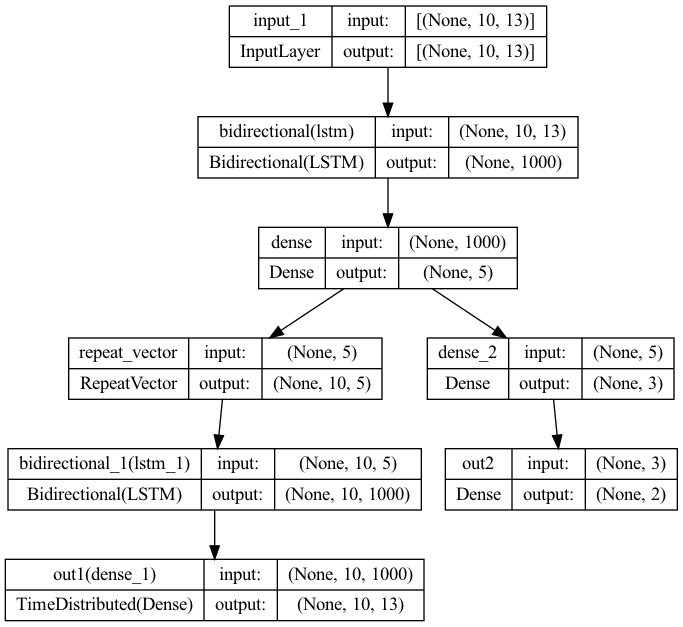

In [20]:
plot_model(model, show_shapes=True)

In [21]:
reset_random_seeds(seed)
# enc.compile(optimizer='adam', loss='binary_crossentropy')
model.compile(optimizer='adam', loss=['mse','binary_crossentropy'],metrics=['accuracy'])
callback=keras.callbacks.EarlyStopping(monitor="val_out2_accuracy", min_delta=1.0e-4, 
                                          patience=100, verbose=0, mode="auto", baseline=None, restore_best_weights=True)
model.fit(LSTM_Train,[LSTM_Train,LSTM_Train_count], epochs=5000, batch_size=2048, validation_data=(Auto_Test, [Auto_Test,LSTM_Test_count]),callbacks=callback, verbose=1, shuffle=True)


Epoch 1/5000
2/2 [==============================] - 5s 2s/step - loss: 0.9080 - out1_loss: 0.2151 - out2_loss: 0.6928 - out1_accuracy: 0.0235 - out2_accuracy: 0.5029 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.6878 - val_out1_accuracy: 0.0032 - val_out2_accuracy: 0.5000
Epoch 2/5000
2/2 [==============================] - 3s 1s/step - loss: 0.8818 - out1_loss: 0.1919 - out2_loss: 0.6899 - out1_accuracy: 0.0365 - out2_accuracy: 0.5000 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.6863 - val_out1_accuracy: 0.0035 - val_out2_accuracy: 0.5000
Epoch 3/5000
2/2 [==============================] - 2s 1s/step - loss: 0.8230 - out1_loss: 0.1320 - out2_loss: 0.6911 - out1_accuracy: 0.0472 - out2_accuracy: 0.5000 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.6934 - val_out1_accuracy: 0.0030 - val_out2_accuracy: 0.5000
Epoch 4/5000
2/2 [==============================] - 2s 1s/step - loss: 0.7723 - out1_loss: 0.0725 - out2_loss: 0.6998 - out1_accuracy: 0.1232 - out2_ac

Epoch 30/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6690 - out1_loss: 0.0276 - out2_loss: 0.6414 - out1_accuracy: 0.6569 - out2_accuracy: 0.6471 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.4510 - val_out1_accuracy: 0.4545 - val_out2_accuracy: 0.8594
Epoch 31/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6687 - out1_loss: 0.0267 - out2_loss: 0.6421 - out1_accuracy: 0.6547 - out2_accuracy: 0.6512 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.4583 - val_out1_accuracy: 0.3289 - val_out2_accuracy: 0.8674
Epoch 32/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6661 - out1_loss: 0.0255 - out2_loss: 0.6406 - out1_accuracy: 0.6599 - out2_accuracy: 0.6544 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.4481 - val_out1_accuracy: 0.4557 - val_out2_accuracy: 0.8662
Epoch 33/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6642 - out1_loss: 0.0245 - out2_loss: 0.6397 - out1_accuracy: 0.6624 - out

Epoch 59/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6351 - out1_loss: 0.0133 - out2_loss: 0.6218 - out1_accuracy: 0.7356 - out2_accuracy: 0.6744 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.4175 - val_out1_accuracy: 0.1188 - val_out2_accuracy: 0.8866
Epoch 60/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6343 - out1_loss: 0.0133 - out2_loss: 0.6210 - out1_accuracy: 0.7325 - out2_accuracy: 0.6700 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.4152 - val_out1_accuracy: 0.0983 - val_out2_accuracy: 0.8860
Epoch 61/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6338 - out1_loss: 0.0130 - out2_loss: 0.6209 - out1_accuracy: 0.7454 - out2_accuracy: 0.6718 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.4144 - val_out1_accuracy: 0.1172 - val_out2_accuracy: 0.8891
Epoch 62/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6311 - out1_loss: 0.0128 - out2_loss: 0.6183 - out1_accuracy: 0.7442 - out

Epoch 88/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6168 - out1_loss: 0.0106 - out2_loss: 0.6062 - out1_accuracy: 0.7839 - out2_accuracy: 0.6847 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.3993 - val_out1_accuracy: 0.1597 - val_out2_accuracy: 0.8916
Epoch 89/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6151 - out1_loss: 0.0103 - out2_loss: 0.6048 - out1_accuracy: 0.7916 - out2_accuracy: 0.6844 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.3985 - val_out1_accuracy: 0.1553 - val_out2_accuracy: 0.8910
Epoch 90/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6148 - out1_loss: 0.0102 - out2_loss: 0.6046 - out1_accuracy: 0.7933 - out2_accuracy: 0.6820 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.3995 - val_out1_accuracy: 0.1256 - val_out2_accuracy: 0.8941
Epoch 91/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6136 - out1_loss: 0.0104 - out2_loss: 0.6032 - out1_accuracy: 0.7742 - out

Epoch 117/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6028 - out1_loss: 0.0094 - out2_loss: 0.5934 - out1_accuracy: 0.8126 - out2_accuracy: 0.6885 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.3871 - val_out1_accuracy: 0.1900 - val_out2_accuracy: 0.8903
Epoch 118/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6017 - out1_loss: 0.0093 - out2_loss: 0.5924 - out1_accuracy: 0.7872 - out2_accuracy: 0.6905 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.3867 - val_out1_accuracy: 0.2646 - val_out2_accuracy: 0.8941
Epoch 119/5000
2/2 [==============================] - 2s 1s/step - loss: 0.6005 - out1_loss: 0.0094 - out2_loss: 0.5911 - out1_accuracy: 0.7898 - out2_accuracy: 0.6982 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.3905 - val_out1_accuracy: 0.3021 - val_out2_accuracy: 0.8934
Epoch 120/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5985 - out1_loss: 0.0094 - out2_loss: 0.5891 - out1_accuracy: 0.8057 -

Epoch 146/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5890 - out1_loss: 0.0083 - out2_loss: 0.5807 - out1_accuracy: 0.7787 - out2_accuracy: 0.7032 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.4057 - val_out1_accuracy: 0.2343 - val_out2_accuracy: 0.8854
Epoch 147/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5885 - out1_loss: 0.0083 - out2_loss: 0.5802 - out1_accuracy: 0.8143 - out2_accuracy: 0.7020 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.3901 - val_out1_accuracy: 0.2521 - val_out2_accuracy: 0.8872
Epoch 148/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5916 - out1_loss: 0.0084 - out2_loss: 0.5832 - out1_accuracy: 0.8112 - out2_accuracy: 0.6988 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.3987 - val_out1_accuracy: 0.3022 - val_out2_accuracy: 0.8860
Epoch 149/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5950 - out1_loss: 0.0083 - out2_loss: 0.5867 - out1_accuracy: 0.7942 -

Epoch 175/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5759 - out1_loss: 0.0075 - out2_loss: 0.5684 - out1_accuracy: 0.8227 - out2_accuracy: 0.7049 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.3919 - val_out1_accuracy: 0.2618 - val_out2_accuracy: 0.8860
Epoch 176/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5754 - out1_loss: 0.0074 - out2_loss: 0.5680 - out1_accuracy: 0.8186 - out2_accuracy: 0.7087 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.3933 - val_out1_accuracy: 0.2921 - val_out2_accuracy: 0.8903
Epoch 177/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5747 - out1_loss: 0.0074 - out2_loss: 0.5673 - out1_accuracy: 0.8093 - out2_accuracy: 0.7064 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.3930 - val_out1_accuracy: 0.3092 - val_out2_accuracy: 0.8885
Epoch 178/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5765 - out1_loss: 0.0074 - out2_loss: 0.5691 - out1_accuracy: 0.8128 -

Epoch 204/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5775 - out1_loss: 0.0075 - out2_loss: 0.5700 - out1_accuracy: 0.8066 - out2_accuracy: 0.7017 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.5821 - val_out1_accuracy: 0.4046 - val_out2_accuracy: 0.6846
Epoch 205/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5777 - out1_loss: 0.0075 - out2_loss: 0.5702 - out1_accuracy: 0.7917 - out2_accuracy: 0.6985 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.6129 - val_out1_accuracy: 0.3090 - val_out2_accuracy: 0.6400
Epoch 206/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5789 - out1_loss: 0.0075 - out2_loss: 0.5714 - out1_accuracy: 0.8007 - out2_accuracy: 0.6982 - val_loss: nan - val_out1_loss: nan - val_out2_loss: 0.6384 - val_out1_accuracy: 0.4686 - val_out2_accuracy: 0.6239
Epoch 207/5000
2/2 [==============================] - 2s 1s/step - loss: 0.5759 - out1_loss: 0.0076 - out2_loss: 0.5682 - out1_accuracy: 0.8139 -

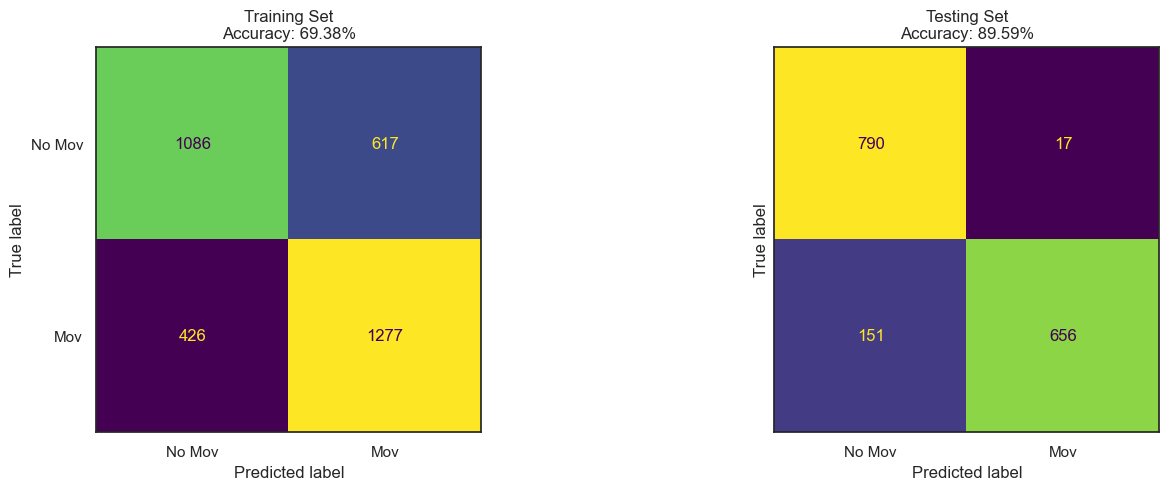

In [22]:
matrix(enc,LSTM_Train, LSTM_Train_count, LSTM_Test, LSTM_Test_count)